## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and MNIST dataset

In [1]:
%load_ext tensorboard

In [2]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [3]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [4]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [5]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [6]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
x_train1 = x_train[-30000:]
y_train1 = y_train[-30000:]
x_train2 = x_train[:-30000]
y_train2 = y_train[:-30000]

In [10]:
# Reserve 10,000 samples for validation
x_val1 = x_train1[-5000:]
y_val1 = y_train1[-5000:]
x_train1 = x_train1[:-5000]
y_train1 = y_train1[:-5000]

x_val2 = x_train2[-5000:]
y_val2 = y_train2[-5000:]
x_train2 = x_train2[:-5000]
y_train2 = y_train2[:-5000]

In [11]:
print('x_train shape:', x_train1.shape)
print(x_train1.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (25000, 28, 28, 1)
25000 train samples
10000 test samples


In [12]:
# convert class vectors to binary class matrices
y_train1 = keras.utils.to_categorical(y_train1, num_classes)
y_val1 = keras.utils.to_categorical(y_val1, num_classes)
y_train2 = keras.utils.to_categorical(y_train2, num_classes)
y_val2 = keras.utils.to_categorical(y_val2, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Define models and compile & fit function

In [13]:
def custom_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [14]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [15]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [16]:
def fit_model1(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train1, y_train1,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val1, y_val1),
                      shuffle=True, callbacks=[tensorboard_callback])

In [17]:
def fit_model2(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train2, y_train2,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val2, y_val2),
                      shuffle=True, callbacks=[tensorboard_callback])

In [37]:
model1 = custom_model()
model2 = tf.keras.models.clone_model(model1)
model2.set_weights(model1.get_weights())

In [38]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
____________________________________________

In [39]:
compile_model(model1)
fit_model1(model1, 10)

Training date and time : 
2020-03-04 13:44:36
Train on 25000 samples, validate on 5000 samples
Epoch 1/10
25000/25000 [==============================] - 21s 837us/sample - loss: 0.0886 - accuracy: 0.2436 - val_loss: 0.0853 - val_accuracy: 0.4654
Epoch 2/10
25000/25000 [==============================] - 23s 901us/sample - loss: 0.0673 - accuracy: 0.5952 - val_loss: 0.0353 - val_accuracy: 0.7848
Epoch 3/10
25000/25000 [==============================] - 24s 952us/sample - loss: 0.0262 - accuracy: 0.8368 - val_loss: 0.0139 - val_accuracy: 0.9192
Epoch 4/10
25000/25000 [==============================] - 23s 936us/sample - loss: 0.0170 - accuracy: 0.8912 - val_loss: 0.0113 - val_accuracy: 0.9284
Epoch 5/10
25000/25000 [==============================] - 21s 851us/sample - loss: 0.0150 - accuracy: 0.9042 - val_loss: 0.0106 - val_accuracy: 0.9310
Epoch 6/10
25000/25000 [==============================] - 21s 858us/sample - loss: 0.0137 - accuracy: 0.9116 - val_loss: 0.0095 - val_accuracy: 0.9368

In [40]:
compile_model(model2)
fit_model2(model2, 10)

Training date and time : 
2020-03-04 13:48:16
Train on 25000 samples, validate on 5000 samples
Epoch 1/10
25000/25000 [==============================] - 22s 864us/sample - loss: 0.0885 - accuracy: 0.2449 - val_loss: 0.0852 - val_accuracy: 0.4118
Epoch 2/10
25000/25000 [==============================] - 21s 827us/sample - loss: 0.0649 - accuracy: 0.5993 - val_loss: 0.0378 - val_accuracy: 0.7532
Epoch 3/10
25000/25000 [==============================] - 20s 809us/sample - loss: 0.0244 - accuracy: 0.8503 - val_loss: 0.0180 - val_accuracy: 0.8878
Epoch 4/10
25000/25000 [==============================] - 21s 840us/sample - loss: 0.0161 - accuracy: 0.8990 - val_loss: 0.0154 - val_accuracy: 0.9020
Epoch 5/10
25000/25000 [==============================] - 21s 854us/sample - loss: 0.0140 - accuracy: 0.9112 - val_loss: 0.0138 - val_accuracy: 0.9094
Epoch 6/10
25000/25000 [==============================] - 21s 847us/sample - loss: 0.0127 - accuracy: 0.9185 - val_loss: 0.0130 - val_accuracy: 0.9144

In [47]:
import numpy as np
theta_list = list(np.arange(0, 1.05, 0.05))

In [48]:
agg_weights = list()

In [49]:
weights = [model1.get_weights(), model2.get_weights()]
agg_weights_list = list()
for theta in theta_list:
    agg_weights = list()
    for weights_list_tuple in zip(*weights):
        agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
    agg_weights_list.append(agg_weights)

In [44]:
scores = list()
for agg_weights in agg_weights_list:
    aggr_model = keras.models.clone_model(model1)
    aggr_model.set_weights(agg_weights)
    compile_model(aggr_model)
    scores.append(aggr_model.evaluate(x_test, y_test));

10000/10000 [==============================] - 2s 159us/sample - loss: 0.0100 - accuracy: 0.9374


In [45]:
scores

[[0.009890898557472974, 0.9378],
 [0.009834034765185788, 0.9379],
 [0.009783718757657335, 0.9382],
 [0.00974072741267737, 0.9379],
 [0.00970450523546897, 0.9378],
 [0.00967449641682906, 0.9379],
 [0.009649169192684348, 0.9379],
 [0.009628829794190824, 0.938],
 [0.009614439655048773, 0.9382],
 [0.00960684694951633, 0.9384],
 [0.00960380956933368, 0.9388],
 [0.009605669262364972, 0.9384],
 [0.009612580286897718, 0.9382],
 [0.009625677241734229, 0.9385],
 [0.009645618424343411, 0.9387],
 [0.009672319525270723, 0.9383],
 [0.009709714310162236, 0.9377],
 [0.009757346639316529, 0.9378],
 [0.009815173924923875, 0.9379],
 [0.009882935781846755, 0.9373],
 [0.009961150336975698, 0.9374]]

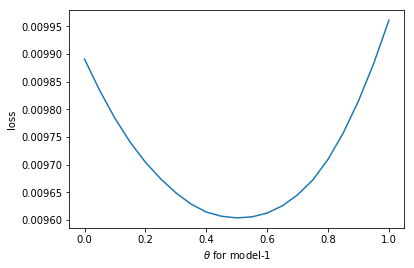

In [46]:
import matplotlib.pyplot as plt
plt.plot(theta_list, [score[0] for score in scores])
plt.xlabel(r'$\theta$ for model-1')
plt.ylabel('loss')
plt.show()

### backup results

In [ ]:
%tensorboard --logdir logs

In [ ]:
a = 2

## @TODO Experiment with pretrained model

In [159]:
pretrained_model1 = tf.keras.models.clone_model(model1)
pretrained_model2 = tf.keras.models.clone_model(model1)

## Sufficiently over-parameterized model

In [162]:
vgg1 = keras.applications.vgg16.VGG16(include_top=False, weights=None, input_tensor=None, input_shape=(28,28,1), pooling=None, classes=10)

ValueError: Input size must be at least 32x32; got `input_shape=(28, 28, 1)`

#### We use 30000 samples to train global model and 30000 samples to simulate data being updated locally

In [ ]:
global_sample_num = 30000

In [ ]:
# it seems like the training data is already in random order
x_train_global = x_train[:global_sample_num]
x_train_local = x_train[global_sample_num:]
y_train_global = y_train[:global_sample_num]
y_train_local = y_train[global_sample_num:]

In [ ]:
def split_local_data(num):
    # if unable to split into same number of datasets,
    # drop last few data
    last_index = 30000 - (30000 % num) 
    x_local = np.split(x_train_local[:last_index], num)
    y_local = np.split(y_train_local[:last_index], num)
    return x_local, y_local

In [ ]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train_global, y_train_global,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_test, y_test_cat),
                      shuffle=True, callbacks=[tensorboard_callback])


#### A few helper functions

In [ ]:
def compile_model_rms(model):  
    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
def print_datetime():
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))

### Test with global model : Tune parameters

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## RQ1: Serial vs. Parallel

#### Serial
30k - 10k - 10k - 10k 


In [ ]:
print_datetime()

serial_model = custom_model()
compile_model(serial_model)
history_serial = serial_model.fit(x_train_global, y_train_global,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = serial_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
history_serial.history['val_acc'][-1]

In [ ]:
serial_model.save("30k_pretrain.h5")

In [ ]:
serial_model = keras.models.load_model('30k_pretrain.h5')

In [ ]:
len(serial_model.layers)

In [ ]:
local_serial_hist = []
split_num = 10

(x_local, y_local) = split_local_data(split_num)

In [ ]:
for i in range(split_num):
    print("Local training #%d" %(i+1))
    serial_model.fit(x_local[i], y_local[i],
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

In [ ]:
serial_model.save("serial_split_10.h5")

#### Parallel
<pre>
       | 10k | 
30k -> | 10k | -> res
       | 10k | 
</pre>

In [ ]:
parallel_model = []
for i in range(split_num):
    parallel_model.append(keras.models.load_model('30k_pretrain.h5')

In [ ]:
for i in range(split_num):
    print("Local training (parallel) #%d" %(i+1))
    parallel_model[i].fit(x_local[i], y_local[i],
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

In [ ]:
weights = [m.get_weights() for m in parallel_model]

In [ ]:
# Federated Aggregation
new_weights = list()

for weights_list_tuple in zip(*weights):
    new_weights.append(
        [np.array(weights_).mean(axis=0)\
            for weights_ in zip(*weights_list_tuple)])

In [ ]:
pretrained_model = keras.models.load_model('30k_pretrain.h5')
aggr_model = keras.models.clone_model(pretrained_model)
aggr_model.set_weights(new_weights)

partial aggregation

In [ ]:
compile_model(aggr_model)
aggr_model.evaluate(x_test, y_test)

In [ ]:
aggr_model.save("parallel_split_10.h5")

serial vs. parallel by devices

In [ ]:
def compare_by_device(lower, upper):
    # Hyperparameter
    lr = 0.001
    
    serial_res = np.zeros(upper - lower + 1)
    parallel_res = np.zeros(upper - lower + 1)
    serial_res[0] = 0.9563
    parallel_res[0] = 0.9563
    for split_num in range(lower, upper):
        print("<=======   Learning with %d devices   =======>" %split_num)
        start_time = datetime.datetime.now() 
        
        #split dataset
        (x_local, y_local) = split_local_data(split_num)
        
        # run serial model
        serial = keras.models.load_model('30k_pretrain.h5')
        for layer in serial.layers[:2]:
            layer.trainable=False
        for layer in serial.layers[2:]:
            layer.trainable=True
        
        compile_model_lr(serial, lr)
        
        for i in range(split_num):
            print("%d devices: Local training (serial) #%d" %(split_num, i+1))
            serial_hist = serial.fit(x_local[i], y_local[i],
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))
        serial_res[split_num - lower + 1] = serial_hist.history['val_acc'][-1]
#         serial.save("bd_serial_split_" + str(split_num) + ".h5")
        
        # run parallel model
        parallel = [keras.models.load_model('30k_pretrain.h5') for _ in range(split_num)]
        for p in parallel:
            for layer in p.layers[:2]:
                layer.trainable=False
            for layer in p.layers[2:]:
                layer.trainable=True
            compile_model_lr(p, lr)
            
        for i in range(split_num):
            print("%d devices: Local training (parallel) #%d" %(split_num, i+1))
            parallel[i].fit(x_local[i], y_local[i],
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(x_test, y_test))
        weights = [m.get_weights() for m in parallel]
        # Federated Aggregation
        new_weights = list()
        for weights_list_tuple in zip(*weights):
            new_weights.append(
                [np.array(weights_).mean(axis=0)\
                    for weights_ in zip(*weights_list_tuple)])
            
        pretrained_model = keras.models.load_model('30k_pretrain.h5')
        aggr_model = keras.models.clone_model(pretrained_model)
        aggr_model.set_weights(new_weights)
        compile_model(aggr_model)
        aggr_score = aggr_model.evaluate(x_test, y_test)
#         aggr_model.save("bd_parallel_split_" + str(split_num) + ".h5")
        parallel_res[split_num - lower + 1] = aggr_score[1]
        
        end_time = datetime.datetime.now() 
        elasped_time = end_time - start_time
        et = divmod(elasped_time.days * 86400 + elasped_time.seconds, 60)
        print("Elasped Time for %d devices: %d minutes, %d seconds" %(split_num, et[0], et[1]))
    return serial_res, parallel_res

In [ ]:
lower = 2
upper = 12
(sr_2, pr_2) = compare_by_device(lower,upper)

In [ ]:
x = np.arange(1,12)
sns.set_style("darkgrid")
plt.axis([0.5, 11, 0.9380, 0.96])
plt.plot(x, sr_2, label='serial')
plt.plot(x, pr_2, label='parallel')
# line for 
l = mlines.Line2D([-0.5,11], [0.9399,0.9399], c='red', label='base')
ax = plt.gca()
ax.add_line(l)
ax.legend()
plt.suptitle('SGD, Fixed, Learning rate: ' + str(0.001))
plt.xlabel('num_devices')
plt.ylabel('validation accuracy')
plt.savefig('SGD_lr001_fixed.png')
plt.show()


### Distributed Model 
#### 90% one class, 10% noise (non-iid)

In [ ]:
num_users = 10

In [ ]:
y_train_local = y_train_noncat[30000:]

In [ ]:
y_train_local.shape

In [ ]:
x_train_skewed = x_train_local[:27000]
x_train_noise = x_train_local[27000:]
y_train_skewed = y_train_local[:27000]
y_train_noise = y_train_local[27000:]

In [ ]:
# make placeholders for datas
x_data_split = [np.empty([0,28,28,1]) for _ in range(num_users)]
y_data_split = [np.empty([0], dtype='uint8') for _ in range(num_users)]

In [ ]:
# split data based on class
for i in range(y_train_skewed.shape[0]):
    if (i%1000 == 0):
        print("%d complete" %i)
    user_num = (int) (y_train_skewed[i]) # user_num is from 0 to 9, depends on class
    x_data_split[user_num] = \
        np.concatenate((x_data_split[user_num], np.expand_dims(x_train_skewed[i], axis=0)), axis=0)
    y_data_split[user_num] = \
        np.concatenate((y_data_split[user_num], np.expand_dims(y_train_skewed[i], axis=0)), axis=0)

In [ ]:
x_noise_split = np.split(x_train_noise, num_users)
y_noise_split = np.split(y_train_noise, num_users)

In [ ]:
for i in range(num_users):
    x_data_split[i] = np.concatenate((x_data_split[i], x_noise_split[i]), axis=0)
    y_data_split[i] = np.concatenate((y_data_split[i], y_noise_split[i]), axis=0)

In [ ]:
for i in range(10):
    print(x_data_split[i].shape)

In [ ]:
y_data_split_cat = []
for yd in y_data_split:
    y_data_split_cat.append(keras.utils.to_categorical(yd, 10))

In [ ]:
parallel_model = []
for i in range(10):
    parallel_model.append(keras.models.load_model('30k_pretrain.h5'))

In [ ]:
for i in range(10):
    print("Local training (parallel) #%d" %(i+1))
    parallel_model[i].fit(x_data_split[i], y_data_split_cat[i],
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

The models that are fed with certain class more than others will distinguish that class with others better

when we are showing 1 class more than the others, are we just increasing tendency of the model to classify as that class, or are we actually helping it to learn more?

confusion matrix, 